## Setup

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
import networkx as nx


In [4]:
df_raw = pd.read_csv('./KaDo.csv')

In [5]:
df = df_raw.copy()
df.head()

TICKET_ID  MOIS_VENTE  PRIX_NET          FAMILLE  \
0   35592159          10      1.67          HYGIENE   
1   35592159          10      1.66          HYGIENE   
2   35592159          10      7.45  SOINS DU VISAGE   
3   35592159          10      5.95  SOINS DU VISAGE   
4   35592159          10      1.67          HYGIENE   

                       UNIVERS                MAILLE  \
0       HYG_DOUCHE JARDINMONDE               HYG_JDM   
1       HYG_DOUCHE JARDINMONDE               HYG_JDM   
2  VIS_CJOUR Jeunes Specifique    VIS_JEUNE_ET_LEVRE   
3               VIS_DEMAQ AAAR  VIS_AAAR_DEMAQLOTION   
4       HYG_DOUCHE JARDINMONDE               HYG_JDM   

                           LIBELLE   CLI_ID  
0    GD JDM4 PAMPLEMOUSSE FL 200ML  1490281  
1    GD JDM4 PAMPLEMOUSSE FL 200ML  1490281  
2  CR JR PARF BIO.SPE AC.SENT.50ML  1490281  
3    EAU MICELLAIRE 3 THES FL200ML  1490281  
4           GD JDM4 TIARE FL 200ML  1490281

In [6]:
df["NB"] = 1

In [7]:
selected_rows = df
selected_rows.shape

(7245522, 9)

In [8]:
df_selected = selected_rows.filter(["TICKET_ID", "LIBELLE"])
df_selected.shape

(7245522, 2)

In [9]:
# t = df_selected.groupby(["TICKET_ID"]).agg(list)
# mask = t["LIBELLE"].apply(lambda x: "GD JDM4 GRENADE FL200ML" in x )
# df_selected = t[mask].explode("LIBELLE").reset_index()

### Keep only ticket with more than 1 article

In [10]:
print(df_selected.shape)
df_selected['cnt'] = df_selected.groupby(['TICKET_ID'])['LIBELLE'].transform('count')
df_selected = df_selected.drop(df_selected[df_selected.cnt<=1].index)[['TICKET_ID', 'LIBELLE']]
print(df_selected.shape)


(7245522, 2)
(6267888, 2)


In [11]:
df_grouped = df_selected.groupby(["TICKET_ID"]).agg(list)
print(df_grouped)
df_grouped["LIBELLE"].tolist()

libelles_list = df_grouped["LIBELLE"].tolist()
libelles_bought_together_list = []
for ticket_libelles in libelles_list:
    libelles_bought_together_list.append(ticket_libelles)

len(libelles_bought_together_list)

                                                     LIBELLE
TICKET_ID                                                   
32931447   [GD LILAS FP FL200ML, GD LILAS FP FL200ML, GLM...
32931448   [EDT VAPO 75 ML TRANSAT, ARA SPLASH TRANSAT 10...
32931452   [GD AMANDE DE CALIF JDM3 FL200ML, SPRAY VOLUME...
32931453   [CRAYON SOURCILS BRUN CN3 1.1G, MASC ULTRA VOL...
32931454   [RAL GRAND RGE COR/INCAN43 CN3 2013 3,7G, RAL ...
...                                                      ...
36529858   [MASC WATER NOIR 01 AX/SO CN3 9ML, KHOL VIOLIN...
36529860   [GEL CR ZERO DEFAUT SEBOVEG 50ML, POUDRE LIBRE...
36529861   [SVC PIEDS BAUME REP T50ml, CR REGENERAT J/N50...
36529863   [EDP MOMENT DE BONHEUR VAPO 30ML, DEO BILLE HO...
36529865   [CD JDM4 AMANDE  FL 200ML, BIO MIEL DOUCHE 200ML]

[1757207 rows x 1 columns]


1757207

In [12]:
from itertools import combinations

### PREPROCESS



In [13]:
selected_filter = "FAMILLE"

In [14]:
df[selected_filter].value_counts()

HYGIENE            2095077
MAQUILLAGE         1694751
SOINS DU VISAGE    1494034
SOINS DU CORPS      878923
PARFUMAGE           628087
CAPILLAIRES         301365
SOLAIRES            153254
MULTI FAMILLES          30
SANTE NATURELLE          1
Name: FAMILLE, dtype: int64

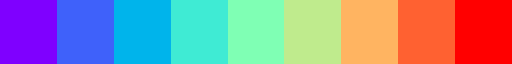

In [15]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

rainbow = cm.get_cmap('rainbow', df[selected_filter].value_counts().shape[0])
rainbow

In [16]:
from sklearn.preprocessing import minmax_scale

min = 0
max = 1


df_color_map = df[selected_filter].unique().copy()
df_color_map = pd.DataFrame(data=df_color_map, columns=[selected_filter])
df_color_map["label"] = minmax_scale(df_color_map.index, feature_range=(min,max))
df_color_map

df_color_map_full = df.filter(["LIBELLE", selected_filter]).groupby(["LIBELLE", selected_filter]).count().reset_index()
df_color_map_full["label"] = list(map(lambda x: df_color_map[df_color_map[selected_filter] == x].iloc[0]['label'], df_color_map_full[selected_filter]))
df_color_map_full["colors"] = list(map(lambda x: rainbow(df_color_map_full[df_color_map_full["label"] == x].iloc[0]['label']), df_color_map_full["label"]))
df_color_dict_full = df_color_map_full.set_index(["LIBELLE"])
df_color_map


FAMILLE  label
0          HYGIENE  0.000
1  SOINS DU VISAGE  0.125
2        PARFUMAGE  0.250
3   SOINS DU CORPS  0.375
4       MAQUILLAGE  0.500
5      CAPILLAIRES  0.625
6         SOLAIRES  0.750
7   MULTI FAMILLES  0.875
8  SANTE NATURELLE  1.000

In [17]:
from IPython.display import clear_output

idx = 0
dic = dict()
for label_list in libelles_bought_together_list:
    l = list(combinations(label_list, 2))
    for tup in l:
        if str(tup[0] + "|" + tup[1]) in dic:

            dic[str(tup[0] + "|" + tup[1])]["size"] += 1
        elif str(tup[1] + "|" + tup[0]) in dic:
            dic[str(tup[1] + "|" + tup[0])]["size"] += 1

        else:
            dic[str(tup[0] + "|" + tup[1])] = {"size": 1, "color": df_color_dict_full["colors"][tup[0]]}
    if idx % 50000 == 0:
        clear_output(wait=True)
        print(str(int(((idx / len(libelles_bought_together_list)) * 100))) + " / " + "100%")
    idx += 1

clear_output()

In [18]:

max = 0;
for key, val in dic.items():
    if max < val["size"]:
        max = val["size"]

print("max: ", max)
min_interraction_percent = 0.1
min_interraction_flat = 100

test_total = list()
for key, val in dic.items():
    if (val["size"] / max >= min_interraction_percent and val["size"] > min_interraction_flat):
        test_total.append((key.split("|")[1], key.split("|")[0], val["size"], val["color"]))

all_network_df = pd.DataFrame(data=test_total, columns=['Src', 'Dst', "size", "color"])

max:  20974


In [19]:

G = nx.from_pandas_edgelist(all_network_df, 'Src', 'Dst',
                            create_using=nx.DiGraph(), edge_attr=['size', "color"])

In [20]:
# G.edges(data=True)

In [21]:
# G.nodes

In [22]:
d = dict(G.degree(weight='size'))

In [23]:
node_colors = list(map(lambda x: df_color_dict_full["colors"][x], d.keys()))

In [24]:
node_sizes_raw = list([v for v in d.values()])

In [25]:
min = 10
max = 1000

X = minmax_scale(node_sizes_raw, feature_range=(min,max))

node_sizes = X

In [26]:
widths = [G[u][v]['size'] for u,v in G.edges]

In [27]:
min = 0.1
max = 10
X = minmax_scale(widths, feature_range=(min,max))

edge_widths = X

In [28]:
edge_colors = [G[u][v]['color'] for u,v in G.edges]

In [29]:
color_dict = df_color_map.set_index(["label"]).to_dict()
labels = [key for key, val in color_dict[selected_filter].items()]
univers = [val for key, val in color_dict[selected_filter].items()]

In [30]:
width = int(all_network_df.shape[0] / 50) + 10
height = int(width / 2) + 5

width = 300 if width > 300 else width
height = 150 if height > 150 else height

width = 200
height = 100

print(width, height)

200 100


In [31]:
df_selected

TICKET_ID                                   LIBELLE
0         35592159             GD JDM4 PAMPLEMOUSSE FL 200ML
1         35592159             GD JDM4 PAMPLEMOUSSE FL 200ML
2         35592159           CR JR PARF BIO.SPE AC.SENT.50ML
3         35592159             EAU MICELLAIRE 3 THES FL200ML
4         35592159                    GD JDM4 TIARE FL 200ML
...            ...                                       ...
7245517   35448190              SVC CR MAINS ET ONGLES T75ml
7245518   35448190        GD JDM4 LAVANDIN DE PROVENCE 200ML
7245519   36105678              CRAYON REGARD PRUNE CN3 1.3G
7245520   36105678          MASCARA SOIN NOIR01 2014 CN3 9ML
7245521   36105678  VAO BRIL CERISE NOIRE113 ETE14 CN3 5,5ML

[6267888 rows x 2 columns]

save in: Graph_494.png


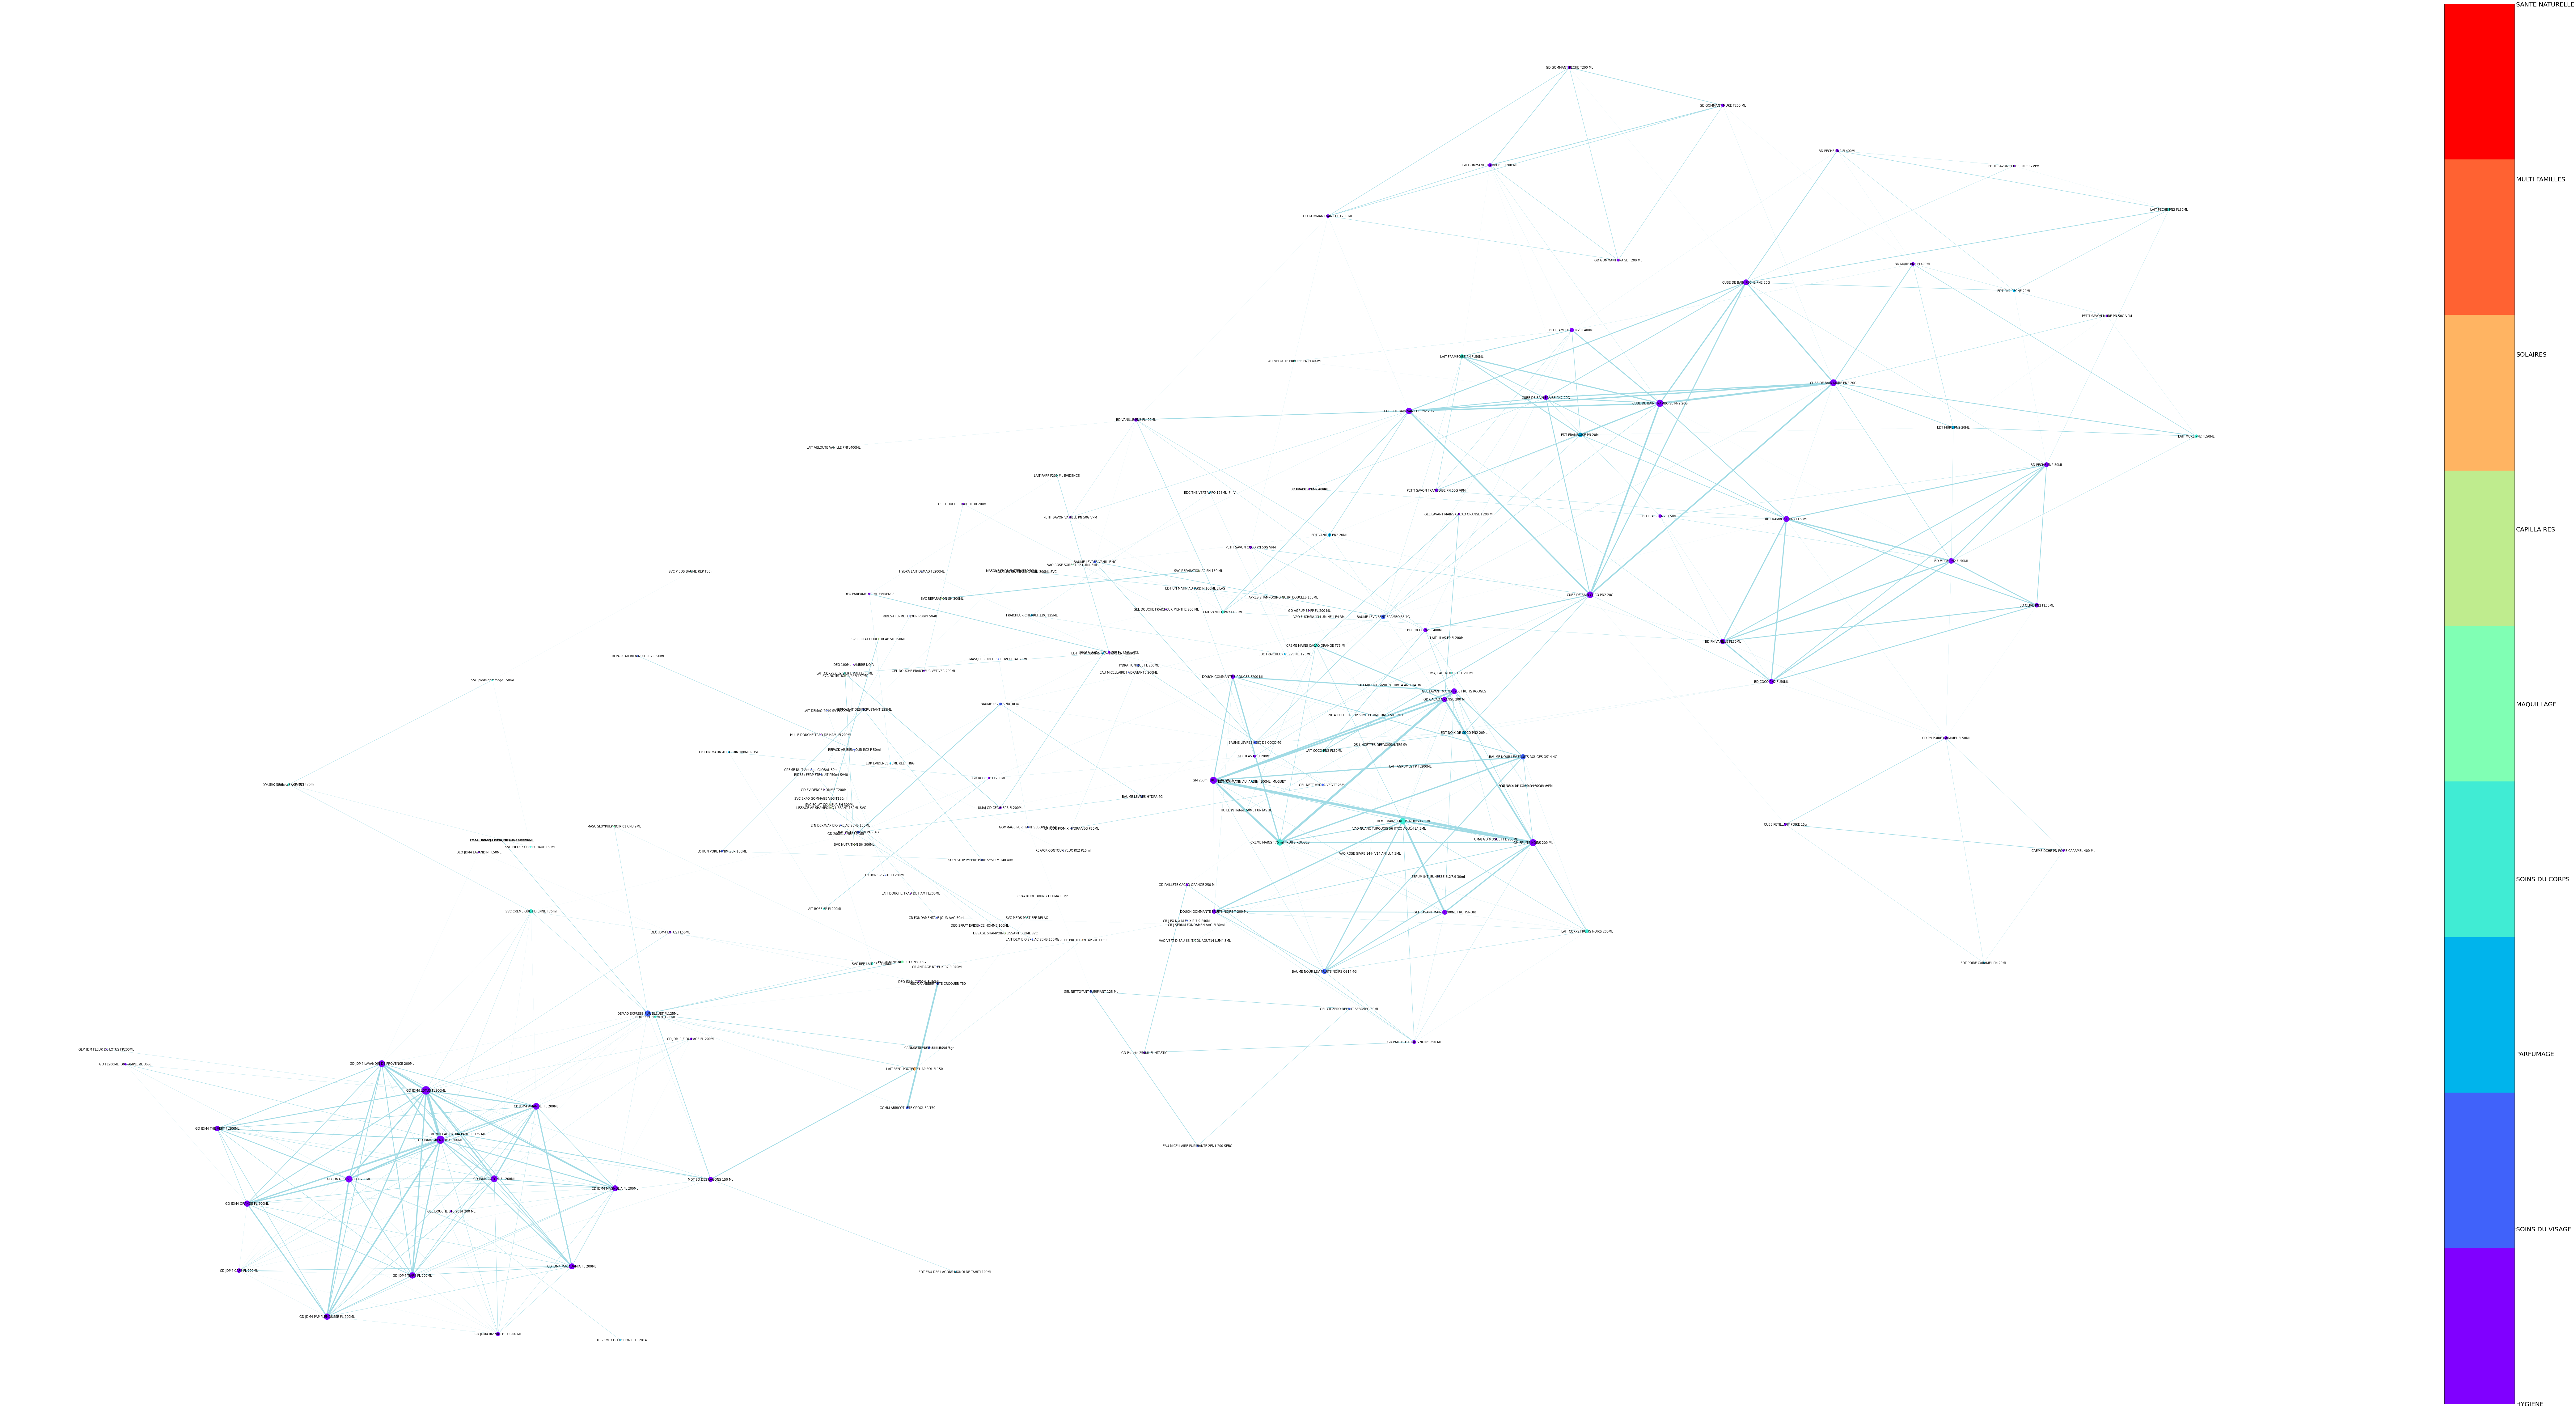

In [32]:
pos = nx.kamada_kawai_layout(G)
fig = plt.figure(1, figsize=(width, height), dpi=60)
mtl = nx.draw_networkx(G,
        ax=fig.add_subplot(111),
        pos=pos,
        arrows=False,
        width=edge_widths,
        with_labels=True, 
        font_weight='normal',
        node_color=node_colors,
        edge_color="#a1dbe5",
        font_color="black",
        font_size=12,
        nodelist=list(d.keys()),
        node_size=node_sizes
    )
sm = plt.cm.ScalarMappable(cmap=rainbow, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm)
cbar.set_ticks(labels)
cbar.set_ticklabels(univers)
cbar.ax.tick_params(labelsize=24)

plt.savefig("Graph_" + str(all_network_df.shape[0]) + ".png", format="PNG")
print("save in: " + "Graph_" + str(all_network_df.shape[0]) + ".png")
plt.show()